In [1]:
cd ..

/home/jevans96/cluster_analysis


In [2]:
import numpy as np
from analysis import tools
from analysis.time_profiles.gauss_profile import gauss_profile
from analysis.time_profiles.uniform_profile import uniform_profile
from analysis.llhs.ps_flare_llh import ps_flare_llh
import glob
from scipy import stats
from matplotlib import pyplot as plt
# import os, sys, glob, abc
# import numpy as np, matplotlib, scipy, time
# from tqdm.notebook import tqdm

# %matplotlib inline
# from matplotlib import pyplot as plt, colors
# from scipy import stats, interpolate, optimize
# import numpy.lib.recfunctions as rf

np.random.seed(0)

In [3]:
# Load in both the simulation and the data

# Where is the dataset stored?
dataset = "/data/mjlarson/data/"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
data = tools.read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
sim = tools.read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
data['angErr'][data['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
sim['angErr'][sim['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)


# Show the possible keys available here:
print("Events available in simulation: {}".format(len(sim)))
print("Keys available in simulation:")
print(sorted(sim.dtype.names))
print()

print("Events available in data: {}".format(len(data)))
print("Keys available in data:")
print(sorted(data.dtype.names))

Events available in simulation: 11595414
Keys available in simulation:
['angErr', 'azi', 'dec', 'event', 'logE', 'ow', 'ra', 'run', 'subevent', 'time', 'trueDec', 'trueE', 'trueRa', 'zen']

Events available in data: 112858
Keys available in data:
['angErr', 'azi', 'dec', 'event', 'logE', 'ra', 'run', 'subevent', 'time', 'zen']


In [4]:
# Also load in the "GoodRunList" (GRL), a file that tells
# us when the detector was taking good data. 
grl_files = dataset + "/GRL/IC86_*exp.npy"
grl = tools.read(glob.glob(grl_files))

# Show the keys available in the GRL
print("Keys available in the GoodRunList:")
print(sorted(grl.dtype.names))

gammas = np.arange(-4.25, -0.5, 0.25)
bins   = np.array([np.linspace(-1, 1, 51), # sin(dec)
                   np.linspace(1, 8, 51)]) # logE

Keys available in the GoodRunList:
['events', 'livetime', 'run', 'start', 'stop']


In [5]:
# Run this block once
llh_object = ps_flare_llh(data, sim, grl, gammas, bins, outfile = './temp_data/ps_flare_llh-test.npy')

/home/jevans96/cluster_analysis/analysis/llhs/ps_flare_llh.py:64: RuntimeWarning: divide by zero encountered in true_divide
  ratio = sig_h / bg_h
/home/jevans96/cluster_analysis/analysis/llhs/ps_flare_llh.py:64: RuntimeWarning: invalid value encountered in true_divide
  ratio = sig_h / bg_h
/home/jevans96/cluster_analysis/analysis/llhs/ps_flare_llh.py:69: RuntimeWarning: invalid value encountered in greater
  good = np.isfinite(values) & (values>0)


In [5]:
# Afterwards, run this one to save time
llh_object = ps_flare_llh(data, sim, grl, gammas, bins, infile = './temp_data/ps_flare_llh-test.npy')

In [6]:
# Produce a single trial. Here, we pass a "seed"
# value to the function so that we can reproduce
# the trial later if we want to. If you want it to
# be random, set seed=None.
seed = 0

# Try this with a gaussian signal + uniform background.
signal_time_profile = gauss_profile(56102.5, 0.01)
background_time_profile = uniform_profile(56102.48, 56102.52)

trial = llh_object.produce_trial(N=1e-15, 
                                 signal_time_profile=signal_time_profile,
                                 background_time_profile=background_time_profile,
                                 random_seed=seed)
print("Got {} events for this trial".format(len(trial)))

print("Times:")
print(trial)

Got 16 events for this trial
Times:
[(    121751, 17568598, 0, 1.36062601, -0.61891759, 3.23841328, 0.95089633, 56102.48561403, 5.22005328, 0.00671682)
 (1106906729,     1418, 0, 1.57855362,  0.52442182, 5.54217078, 2.0789147 , 56102.48973821, 3.79847272, 0.00696632)
 (    121841, 26954936, 0, 0.66543712, -0.50418828, 4.98129674, 1.06729422, 56102.49349585, 5.43093217, 0.00349066)
 (    122271,  3959204, 0, 1.17076064,  0.5644572 , 1.96745349, 2.13410517, 56102.49472966, 2.83791143, 0.01158377)
 (    122051, 40780002, 1, 3.37641558, -0.10622703, 3.07413989, 1.46543164, 56102.49571139, 2.90308996, 0.01085067)
 (    120667, 34861498, 0, 2.03663802,  0.19244637, 2.00954121, 1.76239926, 56102.49894432, 3.04826327, 0.01302006)
 (    120757, 75477798, 0, 4.26552589,  1.03856085, 3.4549358 , 2.60852276, 56102.4991066 , 2.71383485, 0.00971839)
 (    122024, 16235232, 0, 3.65693821,  0.17782283, 2.36213773, 1.74893019, 56102.49919909, 2.90984995, 0.01383804)
 (    121715, 65504829, 0, 1.3968864

In [7]:
sig_time_profile = gauss_profile(56102.5, 0.01)
bg_time_profile = uniform_profile(56102.48, 56102.52)
    
# Run the function with our test trial. Make sure
# you understand what's getting returned!
bestfit = llh_object.evaluate_ts(trial,
                                 bg_time_profile = bg_time_profile,
                                 sig_time_profile = sig_time_profile, 
                                 ns=4, 
                                 gamma=-2,
                                 source = {'ra':np.pi/2, 'dec':np.pi/6})
print(bestfit)


{'ts': 65.25772301770901, 'ns': 1.9999997992799208, 'gamma': -2.0, 't_mean': 56102.502444775746, 't_sigma': 0.009358484086429426}


In [8]:
# Run trials for a few different values of N. These settings should
# exactly mimic your previous script
thousand_seconds = (1000.0)/(24*3600.)
background_time_profile = uniform_profile(56044.0912963, 56044.0912963+thousand_seconds)
signal_time_profile = background_time_profile

args = {"test_ns":0.1,
        "minimize":True, 
        "signal_time_profile":signal_time_profile,
        "background_time_profile":background_time_profile}

background_fits = llh_object.produce_n_trials(1000, **args)
signal_16_fits = llh_object.produce_n_trials(1000, N=1e-16, **args)
signal_15_fits = llh_object.produce_n_trials(1000, N=1e-15, **args)
signal_14_fits = llh_object.produce_n_trials(1000, N=1e-14, **args)

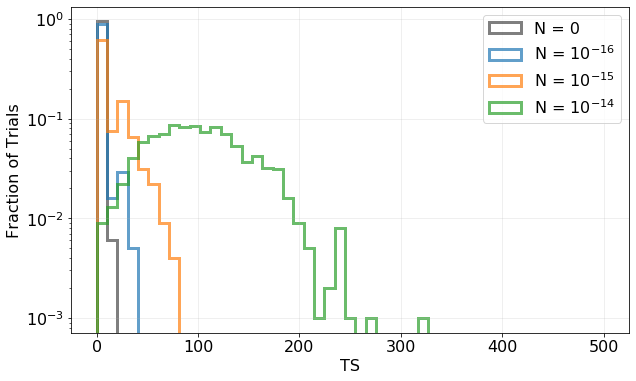

In [11]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 500, 50)

ax.hist(background_fits['ts'],
        bins = bins,
        weights = np.ones(background_fits.shape[0])/len(background_fits),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0')

ax.hist(signal_16_fits['ts'],
        bins = bins,
        weights = np.ones(signal_16_fits.shape[0])/len(signal_16_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-16}$')

ax.hist(signal_15_fits['ts'],
        bins = bins,
        weights = np.ones(signal_15_fits.shape[0])/len(signal_15_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-15}$')

ax.hist(signal_14_fits['ts'],
        bins = bins,
        weights = np.ones(signal_14_fits.shape[0])/len(signal_14_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-14}$')

ax.legend(loc='upper right', fontsize=16,)

ax.grid(alpha=0.25)
ax.set_yscale('log')
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

In [13]:
# Try it again, but using a gaussian signal this time.
# WARNING: The gaussian time profile is kind of hacked
# together and may not give the most reliable results.
# Use with caution!
thousand_seconds = (1000.0)/(24*3600.)
background_time_profile = uniform_profile(56044.0912963, 56044.0912963+thousand_seconds)
signal_time_profile = gauss_profile(56044.0912963 + thousand_seconds/2, thousand_seconds/10)

args = {"test_ns":0.1,
        "minimize":True, 
        "signal_time_profile":signal_time_profile,
        "background_time_profile":background_time_profile}

background_fits = llh_object.produce_n_trials(1000, **args)
signal_16_fits = llh_object.produce_n_trials(1000, N=1e-16, **args)
signal_15_fits = llh_object.produce_n_trials(1000, N=1e-15, **args)
signal_14_fits = llh_object.produce_n_trials(1000, N=1e-14, **args)

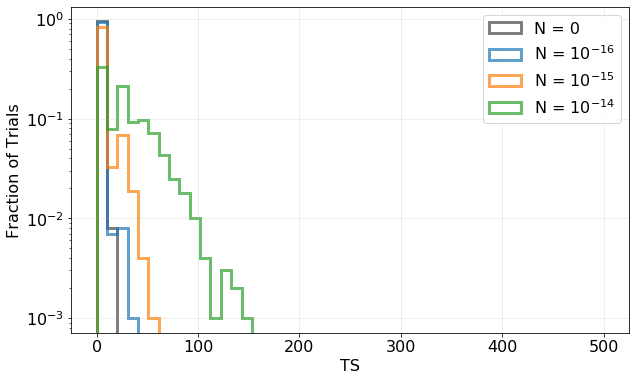

In [14]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 500, 50)

ax.hist(background_fits['ts'],
        bins = bins,
        weights = np.ones(background_fits.shape[0])/len(background_fits),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0')

ax.hist(signal_16_fits['ts'],
        bins = bins,
        weights = np.ones(signal_16_fits.shape[0])/len(signal_16_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-16}$')

ax.hist(signal_15_fits['ts'],
        bins = bins,
        weights = np.ones(signal_15_fits.shape[0])/len(signal_15_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-15}$')

ax.hist(signal_14_fits['ts'],
        bins = bins,
        weights = np.ones(signal_14_fits.shape[0])/len(signal_14_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-14}$')

ax.legend(loc='upper right', fontsize=16,)

ax.grid(alpha=0.25)
ax.set_yscale('log')
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

In [15]:
thousand_seconds = (50000.0)/(24*3600.)
# means  = [56044.0912963 + thousand_seconds/5,56044.0912963 + thousand_seconds/3,
#           56044.0912963 + thousand_seconds/4,56044.0912963 + thousand_seconds/5,
#           56044.0912963 + 3*thousand_seconds/4]
# sigmas = [thousand_seconds/10,thousand_seconds/11,
#           thousand_seconds/8,thousand_seconds/5,
#           thousand_seconds/20]
background_time_profile = uniform_profile(56044.0912963, 56044.0912963+thousand_seconds)
# signal_time_profile = n_gauss_profile(means, sigmas)
signal_time_profile = gauss_profile(56044.0912963 + thousand_seconds/2, thousand_seconds/10)

args = {"signal_time_profile":signal_time_profile,
        "background_time_profile":background_time_profile}



trial = llh_object.produce_trial(N = 1e-14, **args)

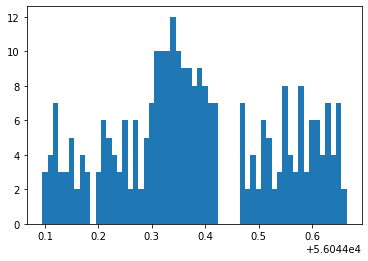

In [16]:
counts, bins, _ = plt.hist(trial['time'], bins = len(trial)//5)

In [17]:
from sklearn.cluster import DBSCAN

In [18]:
X = trial['time'].reshape(-1, 1)
db = DBSCAN(eps=.01, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

In [19]:
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

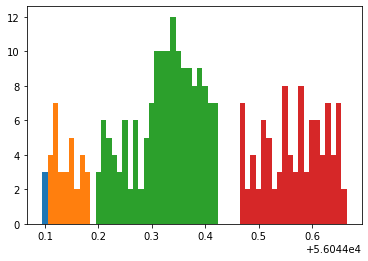

In [20]:
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    
    plt.hist(xy, bins = bins)